### 10x Genomics Visium dataset to study myocardial tissue reorganization following ischemic injury

#### Regions:
1. Control (N= 4)
2. Remote Zone (RZ) (N=5)
3. Ischaemic Zone (IZ) (N=8)


The 10x Genomics Visium heart data from Kuppe et al. is available in the Zenodo data repository: https://zenodo.org/record/6578047.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import scanpy as sc
import graphcompass as gc

## Load data

In [4]:
adata = gc.datasets.visium_heart()
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 88456 × 11669
    obs: 'n_counts', 'n_genes', 'percent.mt', 'Adipocyte', 'Cardiomyocyte', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'Cycling.cells', 'vSMCs', 'cell_type_original', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'sample', 'condition'
    var: 'feature_biotype', 'feature_is_filtered', 'feature_name', 'feature_reference'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'spatial'

In [5]:
adata.obs.head()

,n_counts,n_genes,percent.mt,Adipocyte,Cardiomyocyte,Endothelial,Fibroblast,Lymphoid,Mast,Myeloid,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,sample,condition
AAACAAGTATCTCCCA-1,4429.0,2147,29.575465,0.001598,0.437324,0.024356,0.318303,0.022537,0.003858,0.059224,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control
AAACAATCTACTAGCA-1,3037.0,1591,31.299898,0.000482,0.743949,0.082948,0.089687,0.002331,0.000562,0.039163,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control
AAACACCAATAACTGC-1,2507.0,1462,23.956640,0.001974,0.375296,0.167984,0.151615,0.004123,0.033053,0.009395,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control
AAACAGAGCGACTCCT-1,2502.0,1341,33.018868,0.000110,0.652696,0.095914,0.154588,0.005017,0.000977,0.055517,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control
AAACAGCTTTCAGAAG-1,3054.0,1617,33.638132,0.000084,0.533660,0.164157,0.065999,0.004493,0.001532,0.072105,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control


## Compute distances between cell-type specific subgraphs using portrait method to compare conditions

In [6]:
# define library_key and cluster_key for computing spatial graphs using `squidpy.gr.spatial_neighbors`

library_key="sample"
cluster_key="cell_type_original"
condition_key="condition"

In [7]:
# We're interested in comparing the spatial organization of the following conditions:
subset_conditions = ["control", "RZ", "RZ_GT", "IZ", "GT_IZ"]
adata = adata[adata.obs[condition_key].isin(subset_conditions)]

rename_conditions = {
    "RZ_GT": "RZ",
    "RZ": "RZ",
    "GT_IZ": "IZ",
    "IZ": "IZ",
    "control": "control",
}
adata.obs[condition_key] = [rename_conditions[s] for s in adata.obs[condition_key]]
adata.obs[condition_key] = adata.obs[condition_key].astype('category')
adata.obs

,n_counts,n_genes,percent.mt,Adipocyte,Cardiomyocyte,Endothelial,Fibroblast,Lymphoid,Mast,Myeloid,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,sample,condition
AAACAAGTATCTCCCA-1,4429.0,2147,29.575465,0.001598,0.437324,0.024356,0.318303,0.022537,0.003858,0.059224,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control
AAACAATCTACTAGCA-1,3037.0,1591,31.299898,0.000482,0.743949,0.082948,0.089687,0.002331,0.000562,0.039163,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control
AAACACCAATAACTGC-1,2507.0,1462,23.956640,0.001974,0.375296,0.167984,0.151615,0.004123,0.033053,0.009395,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control
AAACAGAGCGACTCCT-1,2502.0,1341,33.018868,0.000110,0.652696,0.095914,0.154588,0.005017,0.000977,0.055517,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control
AAACAGCTTTCAGAAG-1,3054.0,1617,33.638132,0.000084,0.533660,0.164157,0.065999,0.004493,0.001532,0.072105,...,cardiac muscle myoblast,Visium Spatial Gene Expression,normal,Homo sapiens,female,heart left ventricle,European,44-year-old human stage,control_P1,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1-23,2187.0,1402,20.888208,0.004537,0.279472,0.269585,0.173711,0.006105,0.021762,0.027992,...,cardiac muscle myoblast,Visium Spatial Gene Expression,myocardial infarction,Homo sapiens,male,heart left ventricle,European,52-year-old human stage,RZ_P9,RZ
TTGTTTCACATCCAGG-1-23,3196.0,1798,16.365714,0.000022,0.427789,0.154168,0.036643,0.007050,0.000596,0.275632,...,cardiac muscle myoblast,Visium Spatial Gene Expression,myocardial infarction,Homo sapiens,male,heart left ventricle,European,52-year-old human stage,RZ_P9,RZ
TTGTTTCATTAGTCTA-1-21,1956.0,1217,26.508761,0.000037,0.452197,0.235409,0.157208,0.002246,0.000308,0.012902,...,cardiac muscle myoblast,Visium Spatial Gene Expression,myocardial infarction,Homo sapiens,male,heart left ventricle,European,52-year-old human stage,RZ_P9,RZ
TTGTTTCCATACAACT-1-22,2225.0,1399,18.271301,0.003379,0.157670,0.052058,0.289139,0.002042,0.000447,0.464620,...,immature innate lymphoid cell,Visium Spatial Gene Expression,myocardial infarction,Homo sapiens,male,heart left ventricle,European,52-year-old human stage,RZ_P9,RZ


In [9]:
# compute pairwise similarities between cell-type specific graphs across samples
### results are stored in adata.uns["pairwise_similarities"]

gc.tl.distance.compare_conditions(
    adata=adata,
    library_key=library_key,
    cluster_key=cluster_key,
    method="portrait",
    kwargs_spatial_neighbors={
        'coord_type': 'grid',
        'n_neighs': 6,
    },
)

In [10]:
adata

AnnData object with n_obs × n_vars = 54258 × 11669
    obs: 'n_counts', 'n_genes', 'percent.mt', 'Adipocyte', 'Cardiomyocyte', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'Cycling.cells', 'vSMCs', 'cell_type_original', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'sample', 'condition'
    var: 'feature_biotype', 'feature_is_filtered', 'feature_name', 'feature_reference'
    uns: 'spatial_neighbors', 'cell_type_original_sample_nhood_enrichment', 'pairwise_similarities'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

## Plot results

In [11]:
# define necessary params
condition_key="condition" # key in adata.obs where conditions are stored
control_group="RZ" # reference group

11it [00:01,  5.78it/s]


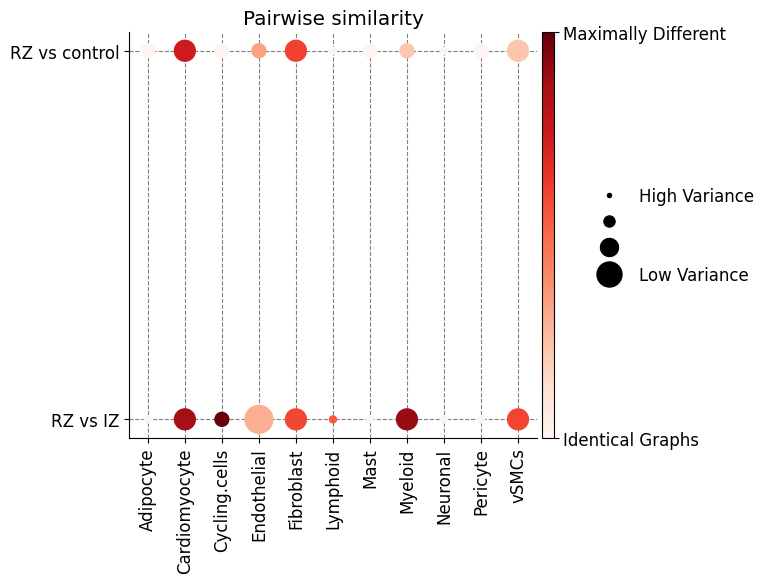

In [14]:
## Note: dot size indicates the variance between samples. The smaller the dot the more variance there is 
## between samples.

gc.pl.distance.compare_conditions(
    adata=adata,
    library_key=library_key,
    condition_key=condition_key,
    control_group=control_group,
    # add_ncells_and_density_plots=True,
    palette="Reds",
    dpi=100,
    figsize=(8,6),
#     save="figures/visium_portrait.pdf"
)